#   ANN

## Imports

In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import math
import statistics

## Collect the data

In [2]:
input_window_size = 10  # this is the no. of input nodes of the NN
start_date = '2010-01-01'
end_date = '2020-12-29'
dates = pd.date_range(start_date, end_date)

In [3]:
filter_dates = pd.DataFrame(index=dates)
df = pd.read_csv('data/Pre_Processed_AAPL.csv', index_col='Date', parse_dates=True,
                    usecols=['Date', 'Adj. Close'], na_values=['nan'])
df = filter_dates.join(df)
df.head()

,Adj. Close
2010-01-01,NaN
2010-01-02,NaN
2010-01-03,NaN
2010-01-04,6.470741
2010-01-05,6.481928


## Feature Engineering

In [4]:
df.isna().sum()

Adj. Close    1249
dtype: int64

In [5]:
df = df.dropna()
df.isna().sum()

Adj. Close    0
dtype: int64

In [6]:
df.shape

(2767, 1)

## Normalize the data

In [7]:
# Normalization and Denormalization constants
# denorm_const = df['Adj. Close'].iloc[0]: Đây là việc gán giá trị của cột 'Adj. Close' từ DataFrame df vào biến denorm_const. .iloc[0] được sử dụng để lấy giá trị đầu tiên trong cột 'Adj. Close'. Đây có thể là giá trị của cột 'Adj. Close' cho hàng đầu tiên trong DataFrame.

# norm_const = 1/denorm_const: Đây là việc tính toán giá trị của hằng số chuẩn hóa (norm_const). Hằng số này được tính bằng cách lấy giá trị nghịch đảo của denorm_const. Điều này có thể đang thực hiện một phương pháp chuẩn hóa dữ liệu bằng cách chia mỗi giá trị của cột 'Adj. Close' cho giá trị đầu tiên của cột đó. Điều này giúp chuẩn hóa dữ liệu sao cho giá trị ban đầu của cột 'Adj. Close' bằng 1.

# Ví dụ, nếu giá trị đầu tiên của cột 'Adj. Close' là 100, thì denorm_const sẽ là 100 và norm_const sẽ là 0.01 (1/100).
denorm_const = df['Adj. Close'].iloc[0]
norm_const = 1/denorm_const

denorm_const, norm_const

(6.470741272, 0.15454179945768662)

In [8]:
# Normalize
df = df*norm_const
df.head()

,Adj. Close
2010-01-04,1.000000
2010-01-05,1.001729
2010-01-06,0.985795
2010-01-07,0.983973
2010-01-08,0.990515


## Bollinger Bands

In [9]:
def get_rolling_mean(df_, window):
    return df_.rolling(window).mean()

def get_rolling_std(df_, window):
    return df_.rolling(window).std()

def get_bollinger_bands(rm, rstd):
    upper_band = rm + 2*rstd
    lower_band = rm - 2*rstd
    return upper_band, lower_band

def clip_to_bollinger_bands(df_, window):
    rm = get_rolling_mean(df_, window=window)
    rstd = get_rolling_std(df_, window=window)
    upper_band, lower_band = get_bollinger_bands(rm, rstd)
    return df_.clip(upper=upper_band, lower=lower_band)

In [10]:
def plot_df(df, title="Default Title"):
    ax = df.plot()
    ax.set_xlabel(title)
    ax.get_legend().remove()
    plt.show()

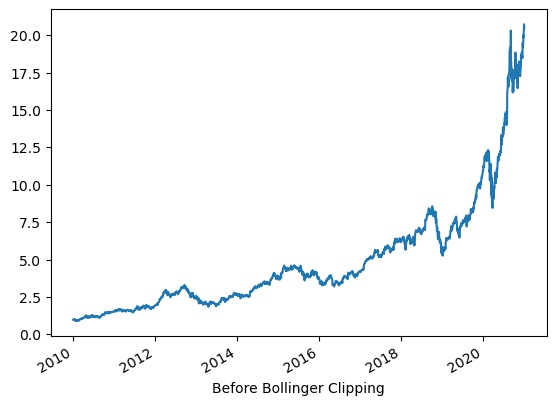

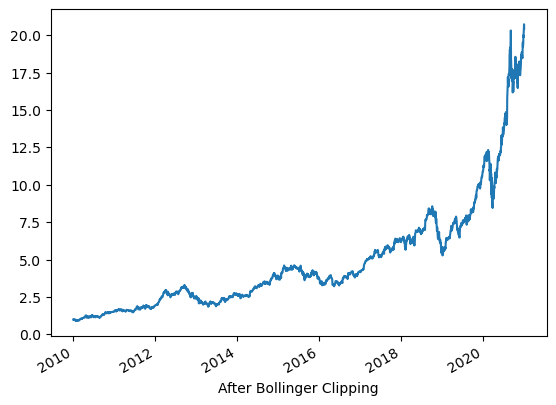

In [11]:
plot_df(df, "Before Bollinger Clipping")
df = clip_to_bollinger_bands(df, input_window_size)
plot_df(df, "After Bollinger Clipping")

After Bollinger Clipping we have first (input_window_size - 1) elements as NaN

In [12]:
df.head(15)

,Adj. Close
2010-01-04,1.000000
2010-01-05,1.001729
2010-01-06,0.985795
2010-01-07,0.983973
2010-01-08,0.990515
2010-01-11,0.981777
2010-01-12,0.970609
2010-01-13,0.984300
2010-01-14,0.978599
2010-01-15,0.962245


In [13]:
df.isna().sum()

Adj. Close    0
dtype: int64

In [14]:
df = df.dropna()
print(df.isna().sum())
print(df.shape)

Adj. Close    0
dtype: int64
(2767, 1)


In [15]:
data = list(df['Adj. Close'])
len(data)

2767

## Train, Validation and Test data

Train : Test = 80 : 20

In [16]:
train_till = int(0.8*len(data))

train_raw_data = data[:train_till]
test_raw_data = data[train_till:]

train_features = [train_raw_data[i:i+input_window_size] for i in range(len(train_raw_data)-input_window_size)]
test_features = [test_raw_data[i:i+input_window_size] for i in range(len(test_raw_data)-input_window_size)]

train_labels = train_raw_data[input_window_size:]
test_labels = test_raw_data[input_window_size:]

print(len(train_features), len(train_labels))
print(len(test_features), len(test_labels))

2203 2203
544 544


In [17]:
train_features = np.array(train_features)
test_features = np.array(test_features)

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

print(train_features.shape, train_labels.shape)
print(test_features.shape, test_labels.shape)

(2203, 10) (2203,)
(544, 10) (544,)


## Build the model

### Activation Function

In [18]:
# #Đoạn mã trên định nghĩa hai hàm kích hoạt (activation function) và đạo hàm của chúng:

# Hàm ReLU (Rectified Linear Unit):
# Hàm relu(x) tính toán giá trị ReLU của mỗi phần tử trong mảng x. ReLU là một hàm kích hoạt phi tuyến tính, được định nghĩa bằng cách trả về giá trị của x nếu x lớn hơn 0 và trả về 0 nếu x nhỏ hơn hoặc bằng 0. Hàm này giúp loại bỏ sự phi tuyến tính và tăng tính toàn vẹn của mô hình, đồng thời giảm thiểu vấn đề biến mất gradient (vanishing gradient problem).
# Đạo hàm của hàm ReLU:
# Hàm der_relu(x) tính toán đạo hàm của hàm ReLU tại mỗi điểm trong mảng x. Đạo hàm của ReLU bằng 1 nếu x lớn hơn 0 và bằng 0 nếu x nhỏ hơn hoặc bằng 0. Đạo hàm này được sử dụng trong quá trình lan truyền ngược (backpropagation) để cập nhật trọng số của mạng neural network trong quá trình huấn luyện.
def relu(x):
    return np.array([i if i > 0 else 0 for i in x])

def der_relu(x):
    return np.array([1 if i > 0 else 0 for i in x])

### Hyperparameters

In [27]:
# n_epochs: Đây là số lượng epochs (vòng lặp qua toàn bộ tập dữ liệu huấn luyện) được sử dụng trong quá trình huấn luyện mô hình. Trong trường hợp này, mô hình sẽ được huấn luyện trong 200 epochs.

# lr: Đây là tỷ lệ học (learning rate), là một tham số quan trọng trong quá trình huấn luyện mạng neural network. Learning rate quyết định tốc độ cập nhật trọng số của mạng trong mỗi bước huấn luyện. Tỷ lệ học càng cao, thì mô hình sẽ hội tụ nhanh hơn, nhưng có thể dễ dàng bị văng vẳng (overshoot) qua giá trị tối ưu. Trong trường hợp này, learning rate được đặt là 0.00005, có vẻ như là một giá trị nhỏ, cho phép mô hình học một cách chậm và ổn định. Điều này có thể hữu ích trong việc học từ dữ liệu nhiễu hoặc dữ liệu có cấu trúc phức tạp.
n_epochs = 200
lr = 0.00005

### Input and Output Nodes and Weight Matrix

In [28]:
# input_nodes = input_window_size: Đây là số lượng nút (neurons) trong lớp đầu vào của mạng neural network. Trong trường hợp này, input_nodes được đặt bằng input_window_size, tức là số lượng features (đặc trưng) trong mỗi mẫu dữ liệu đầu vào.

# output_nodes = 1: Đây là số lượng nút trong lớp đầu ra của mạng neural network. Trong trường hợp này, output_nodes được đặt là 1, do mô hình đang được sử dụng để dự đoán một giá trị đầu ra duy nhất (ví dụ: giá cổ phiếu tiếp theo).

# weight_matrix = np.random.uniform(size=(input_nodes, output_nodes)): Đoạn mã này tạo ra ma trận trọng số ngẫu nhiên có kích thước input_nodes x output_nodes. Mỗi phần tử trong ma trận này đại diện cho trọng số của mỗi kết nối giữa mỗi nút trong lớp đầu vào và nút trong lớp đầu ra của mạng neural network. Giá trị của các trọng số được chọn ngẫu nhiên từ phân phối đồng nhất trong khoảng từ 0 đến 1. Ma trận này sẽ được sử dụng trong quá trình lan truyền tiến (forward propagation) để tính toán giá trị đầu ra của mạng dựa trên dữ liệu đầu vào và các trọng số.



input_nodes = input_window_size
output_nodes = 1

weight_matrix = np.random.uniform(size=(input_nodes, output_nodes))
weight_matrix.shape

(10, 1)

### Train the model

In [29]:
# Vòng lặp qua các epochs:

# Dòng for epoch in range(n_epochs): tạo ra một vòng lặp chạy qua các epochs, với số lượng epochs được xác định trước bởi biến n_epochs.
# In ký tự . sau mỗi 10 epochs:

# Dòng if epoch % 10 == 0: print() in ra một dòng trống sau mỗi 10 epochs, để theo dõi tiến trình của quá trình huấn luyện.
# In dấu . sau mỗi epoch:

# Dòng print('.', end='') in ra dấu chấm sau mỗi epoch, để theo dõi tiến trình của quá trình huấn luyện.
# Lan truyền tiến (forward propagation):

# Dòng output_node_input = train_features.dot(weight_matrix).flatten() tính toán giá trị đầu vào của lớp đầu ra bằng cách nhân ma trận đầu vào (train_features) với ma trận trọng số (weight_matrix) và làm phẳng kết quả để thu được một vector.
# Áp dụng hàm kích hoạt ReLU:

# Dòng output = relu(output_node_input) áp dụng hàm kích hoạt ReLU lên giá trị đầu vào của lớp đầu ra, để thu được giá trị đầu ra của mạng.
# Tính toán lỗi:

# Dòng error = train_labels - output tính toán lỗi bằng cách lấy hiệu của giá trị thực tế (train_labels) và giá trị dự đoán (output).
# Tính toán delta_weight:

# Dòng drv = der_relu(output_node_input) tính toán đạo hàm của hàm kích hoạt ReLU tại giá trị đầu vào của lớp đầu ra.
# Dòng delta_weight = error * drv tính toán delta_weight bằng cách nhân lỗi với đạo hàm của hàm kích hoạt, để thu được mức độ thay đổi của trọng số cần áp dụng trong quá trình cập nhật trọng số.
# Cập nhật trọng số:

# Dòng weight_matrix = weight_matrix + lr * train_features.T.dot(delta_weight.reshape(train_features.shape[0], 1)) cập nhật trọng số bằng cách thêm một khoảng thay đổi tính toán được vào ma trận trọng số. Độ lớn của khoảng thay đổi được điều chỉnh bởi tỷ lệ học (lr).
for epoch in range(n_epochs):
    if epoch%10 == 0: print()
    print('.', end='')
    output_node_input = train_features.dot(weight_matrix).flatten()
    output = relu(output_node_input)
    error = train_labels - output
    drv = der_relu(output_node_input)
    delta_weight = error * drv
    weight_matrix = weight_matrix + lr * train_features.T.dot(delta_weight.reshape(train_features.shape[0], 1))


..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........

In [30]:
output[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Prediction

In [31]:
# Dòng mã trên tính toán các dự đoán trên tập kiểm tra bằng cách sử dụng mạng neural network đã được huấn luyện và áp dụng hàm kích hoạt ReLU cho giá trị đầu ra của lớp đầu ra.

# test_features.dot(weight_matrix): Tính toán giá trị đầu vào của lớp đầu ra bằng cách nhân ma trận đặc trưng kiểm tra (test_features) với ma trận trọng số đã được huấn luyện (weight_matrix). Kết quả là một vector chứa giá trị đầu vào của mỗi mẫu trong tập kiểm tra.

# .flatten(): Làm phẳng kết quả để thu được một vector.

# relu(): Áp dụng hàm kích hoạt ReLU lên các giá trị đầu vào để tính toán các dự đoán cuối cùng trên tập kiểm tra. Điều này được thực hiện để đảm bảo rằng các giá trị đầu ra là không âm và không bị giảm mất tính phi tuyến tính của mô hình.
test_predictions = relu(test_features.dot(weight_matrix).flatten())

In [32]:
test_predictions[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

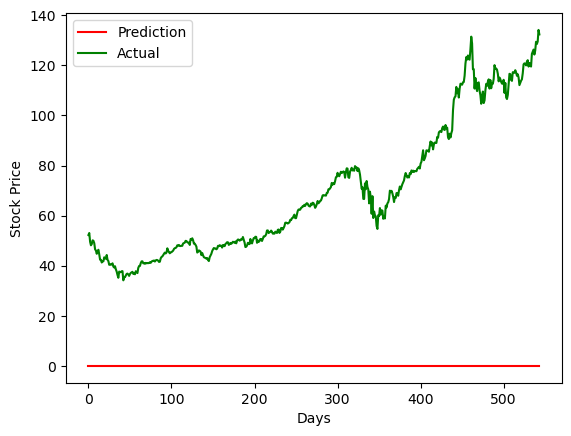

In [33]:
plt.figure()
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.plot(test_predictions*denorm_const, 'r', label='Prediction')
plt.plot(test_labels*denorm_const, 'g', label='Actual')
plt.legend()
plt.show()

In [34]:
mae = np.mean(np.abs(test_labels - test_predictions ))
print(mae)
rmse = np.sqrt(np.mean((test_labels - test_predictions) ** 2))
print(rmse)
#tính độ chính xác của dự báo
mape = np.mean(np.abs((test_labels - test_predictions )/ test_labels)) *100
print(mape)

10.73433043562837
11.50893478454238
100.0
